# U.S. Medical Insurance Costs

In [22]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from scipy import stats
import seaborn as sns

In [23]:
df = pd.read_csv("insurance.csv")

In [24]:
display(df.head())

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


## INITIAL EDA

In [25]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


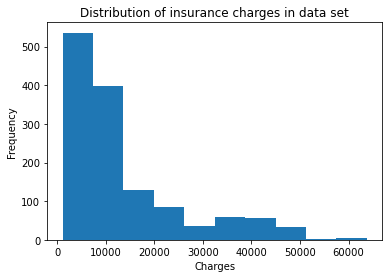

In [26]:
plt.hist(df['charges'])
plt.xlabel('Charges')
plt.ylabel('Frequency')
plt.title('Distribution of insurance charges in data set')
plt.show()

Non-normal distributution, but we have a large number data points. 

In [27]:
display(df['sex'].value_counts())

male      676
female    662
Name: sex, dtype: int64

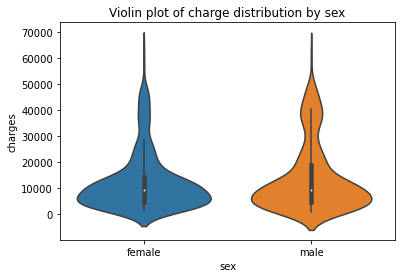

In [28]:
sns.violinplot(x = 'sex',y='charges', data = df)
plt.title('Violin plot of charge distribution by sex')
plt.show()

In [29]:
df['region'].value_counts()

southeast    364
southwest    325
northwest    325
northeast    324
Name: region, dtype: int64

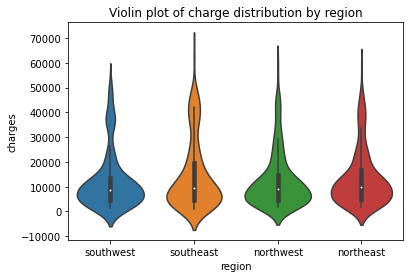

In [30]:
sns.violinplot(x='region', y = 'charges', data = df)
plt.title('Violin plot of charge distribution by region')
plt.show()

Fairly equal representations of both sexes and all four regions. Neither seem to have important relationships with the insurance charges.

In [31]:
df['children'].value_counts()

0    574
1    324
2    240
3    157
4     25
5     18
Name: children, dtype: int64

,children,age,bmi,charges
0,0,38.444251,30.550296,12365.975602
1,1,39.453704,30.623148,12731.171832
2,2,39.445833,30.978104,15073.563734
3,3,41.566879,30.684331,15355.318367
4,4,39.000000,31.391200,13850.656311
5,5,35.611111,29.605000,8786.035247


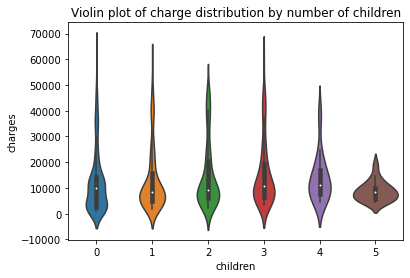

In [32]:
child_df = df.groupby('children', as_index = False).mean()
display(child_df)
sns.violinplot(x='children', y = 'charges', data = df)
plt.title('Violin plot of charge distribution by number of children')
plt.show()

People with 2 or 3 children seem to pay more than the rest, investigate futher.

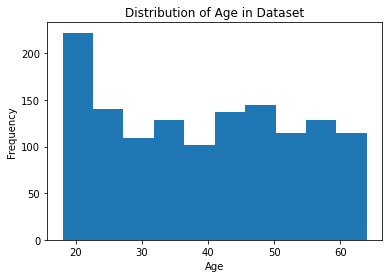

In [33]:
plt.hist(df['age'])
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Distribution of Age in Dataset')
plt.show()

More young people in the data set than old. Is this representative of the general population of America?

In [34]:
num_df = df[['age', 'bmi','charges']]
num_df_corr = num_df.corr()
num_df_corr['charges']


age        0.299008
bmi        0.198341
charges    1.000000
Name: charges, dtype: float64

Age and bmi correlate positively with charges, so these should be investigated further.

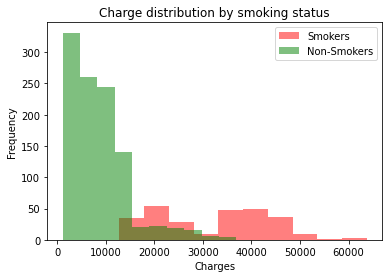

In [35]:
smoker_charges = df[ df['smoker'] == 'yes']['charges'].to_numpy()
nonsmoker_charges = df[ df['smoker'] == 'no']['charges'].to_numpy()
plt.hist(smoker_charges,color ='red', alpha = 0.5, label = 'Smokers')
plt.hist(nonsmoker_charges,color ='green', alpha = 0.5, label = 'Non-Smokers')
plt.xlabel('Charges')
plt.ylabel('Frequency')
plt.title('Charge distribution by smoking status')
plt.legend()
plt.show()

Smoking appears to greatly increase the cost of insurance, investigate this further as well.

### Initial findings
See that we have a decently distributed data set by sex and location. The data set contains more young people ~20yo than any other age group so this will need to be taken into account. 
We see that bmi and age both positively correlate with charges, so these will need to be investigated, as well as smoking status which shows a clear increase in charges from a quick visual inspection.

## SMOKING DEPENDANCE

In [36]:
smoke_df  = df.groupby('smoker').mean()
charge_smoker = smoke_df['charges'][1]
charge_nonsmoker = smoke_df['charges'][0]
diff_smoker = charge_smoker - charge_nonsmoker
sd = df['charges'].std()
num_sd_smoker_diff = diff_smoker/sd
print('Average insurance cost for smoker: ${:.2f}'.format(charge_smoker))
print('Average insurance cost for non-smoker: ${:.2f}'.format(charge_nonsmoker))
print('Number of standard deviations of charge increase if smoker: {}'.format(num_sd_smoker_diff))
print('Percentage increase in charge if smoker: {:.2f} %'.format(charge_smoker/charge_nonsmoker*100-100))

Average insurance cost for smoker: $32050.23
Average insurance cost for non-smoker: $8434.27
Number of standard deviations of charge increase if smoker: 1.950119043830363
Percentage increase in charge if smoker: 280.00 %


In [37]:
# Do a Welches t test to check if significant increase
smoker_charges = df[ df['smoker'] == 'yes']['charges'].to_numpy()
nonsmoker_charges = df[ df['smoker'] == 'no']['charges'].to_numpy()
print((smoker_charges.std() - nonsmoker_charges.std())/smoker_charges.std()) # difference in std is less than half a std so can assume equal variances
stats.ttest_ind(smoker_charges,nonsmoker_charges, alternative = 'greater')


0.47997206338072007


Ttest_indResult(statistic=46.66492117272371, pvalue=4.135717921089551e-283)

### Smokers findings
There is a 280% increase in insurance charges for people who smoke. This increase is significant with a p value of $10^{-283}$

## AGE DEPENDANCE


<BarContainer object of 5 artists>

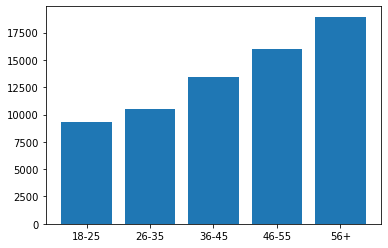

In [38]:
age_df = df.groupby('age', as_index = False).mean()
a18_25 = age_df[ ( age_df['age'] >= 18 ) & ( age_df['age'] <= 25)].mean(axis = 0).charges
a26_35 = age_df[ ( age_df['age'] >= 26 ) & ( age_df['age'] <= 35)].mean(axis = 0).charges
a36_45 = age_df[ ( age_df['age'] >= 36 ) & ( age_df['age'] <= 45)].mean(axis = 0).charges
a46_55 = age_df[ ( age_df['age'] >= 46 ) & ( age_df['age'] <= 55)].mean(axis = 0).charges
a56p =  age_df[ age_df['age']>= 56].mean(axis = 0).charges
age_split = [a18_25, a26_35,a36_45, a46_55, a56p]
age_split_labels = [r'18-25', r'26-35',r'36-45',r'46-55',r'56+']
plt.bar(age_split_labels, age_split)

Clearly there is a gradual increase in insurance with age

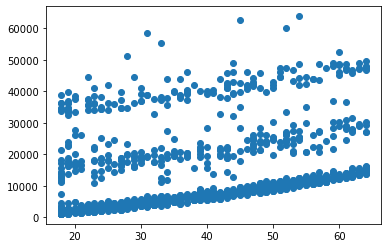

In [39]:
age_vector = df['age'].to_numpy()
charge_vector = df['charges'].to_numpy()
plt.scatter(age_vector, charge_vector)

Interesting, there is a clear increase with age, however there seem to be grades within that that cause higher charges, could this be due to smoking? 

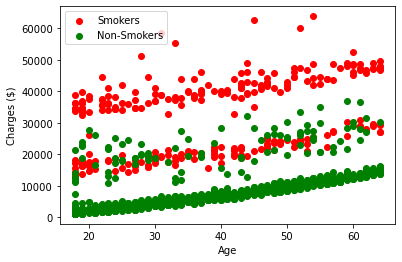

In [40]:
smoking_boolean = df['smoker'] == 'yes'
nonsmoking_boolean = df['smoker'] == 'no'
plt.scatter(age_vector[smoking_boolean], charge_vector[smoking_boolean], c= 'red', label='Smokers')
plt.scatter(age_vector[nonsmoking_boolean], charge_vector[nonsmoking_boolean], c= 'green', label='Non-Smokers')
plt.xlabel('Age')
plt.ylabel('Charges ($)')
plt.legend()

Clearly shown that age increases the charges in general, and that smoking status can account for higher charges for a certain age, however there must be other factors at play.

## BMI

Maybe this is another factor for increased charges

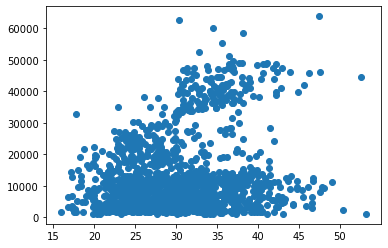

In [41]:
bmis = df['bmi']
plt.scatter(bmis, charge_vector)

Does not seem to be a strong relationship between bmi and charges, as many high bmi people pay the same. However, there does appear to be a threshold at around 30, the bmi for obesity. So lets quickly look at this.

In [42]:
obese_charges = df[ df['bmi'] >= 30]['charges']
nonobese_charges =  df[ df['bmi'] < 30]['charges']
print('Increase in charges due to obesity: {:.2f} %'.format(obese_charges.mean()/nonobese_charges.mean()*100-100))

Increase in charges due to obesity: 45.16 %


In [43]:
# Check to see if significant increase
stats.ttest_ind(obese_charges,nonobese_charges, alternative = 'greater')


Ttest_indResult(statistic=7.442815495893551, pvalue=8.792780636975613e-14)

So obesity is another factor causing increase in charges (significant increase). Does this explain the other gradations in the age vs charge plot?

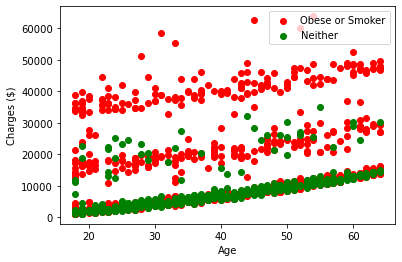

In [44]:
obese_boolean = df['bmi'] >= 30
nonobese_boolean = df['bmi'] < 30
bad = obese_boolean | smoking_boolean
good = nonsmoking_boolean & nonobese_boolean
plt.scatter(age_vector[bad], charge_vector[bad], c= 'red', label='Obese or Smoker')
plt.scatter(age_vector[good], charge_vector[good], c= 'green', label='Neither')
plt.xlabel('Age')
plt.ylabel('Charges ($)')
plt.legend()

We have managed to identify two of the factors causing increased charges for a given age.

## CHILDREN


## OBESE AND SMOKER

As a last investigation, lets compare those who are obese and smoke to the rest of the set


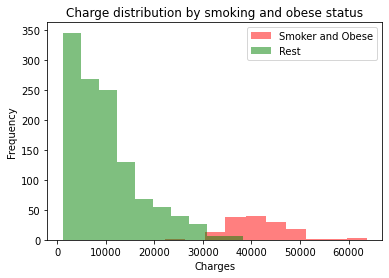

In [45]:
smoke_obese = smoking_boolean & obese_boolean
rest = nonsmoking_boolean | nonobese_boolean
plt.hist(charge_vector[smoke_obese],color ='red', alpha = 0.5, label = 'Smoker and Obese')
plt.hist(charge_vector[rest],color ='green', alpha = 0.5, label = 'Rest')
plt.xlabel('Charges')
plt.ylabel('Frequency')
plt.title('Charge distribution by smoking and obese status')
plt.legend()
plt.show()

Clearly this is a huge factor


In [57]:
print('Increase in charges for those who smoke and are obese: {:.2f} %'.format(charge_vector[smoke_obese].mean()/charge_vector[rest].mean()*100 - 100))
stats.ttest_ind(charge_vector[smoke_obese], charge_vector[rest], alternative = 'greater')

Increase in charges for those who smoke and are obese: 322.67 %


Ttest_indResult(statistic=51.34519192347729, pvalue=1.007667e-318)

# SUMMARY AND CONCLUSIONS